In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import glob
from scipy import stats
import pingouin as pg
import xarray as xr
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import dataframe_image as dfi
import sys
sys.path.insert(0, '/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability')
import tool_box

colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

std_colors = np.array([(255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15), 
(223,99,98), (180,51,88), (144,13,164)])/255

std_cmap = LinearSegmentedColormap.from_list('cmap', std_colors)


def correlation_matrix_creator(predictors_and_target_df):
    predictors_and_target_df = predictors_and_target_df.to_numpy()
    corr_matrx = []
    for ts_1 in range(len(predictors_and_target_df.T)):
        corr_row = []
        for ts_2 in range(len(predictors_and_target_df.T)):
            timeseries_1 = predictors_and_target_df[:,ts_1]
            timeseries_2 = predictors_and_target_df[:,ts_2]
            N = len(timeseries_1)
            r = stats.pearsonr(timeseries_1[:], timeseries_2[:])[0]
            r1_autocorrelation = stats.pearsonr(timeseries_1[1:], timeseries_1[:-1])[0]
            r2_autocorrelation = stats.pearsonr(timeseries_2[1:], timeseries_2[:-1])[0]
            N_star = N*((1-r1_autocorrelation*r2_autocorrelation)/
                        (1+r1_autocorrelation*r2_autocorrelation))
            tcrit = stats.t.ppf(1-0.025, N_star)
            t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))
            if abs(t) - tcrit > 0:
                significant = 1
            else:
                significant = 0
            corr_row.append([r, significant])
        corr_matrx.append(corr_row)
    return np.array(corr_matrx)

def cf_profile_finder(cf_prof_maps):
    cf_prof_maps_ = np.sort(cf_prof_maps)
    profile_cf = np.array([np.load(cf_prof_maps_[yr])[0] for yr in range(len(cf_prof_maps_))])
    empty_prof_map = np.empty(np.shape(profile_cf[:5]))
    empty_prof_map[:] = np.NaN
    profile_cf = np.concatenate((empty_prof_map, profile_cf), axis=0)
    print(np.shape(profile_cf))
    profile_cf = np.reshape(profile_cf, (16,12,24,144,221))
    profile_cf[10,1] = np.nanmean([profile_cf[10,0], profile_cf[10,2]], axis=0)
    profile_cf_anoms = profile_cf - np.nanmean(profile_cf, axis=0)
    profile_cf_anoms_zm = np.nanmean(np.reshape(profile_cf_anoms, (16,12,24,144,221)), axis=3)
    profile_cf_anoms_ts = np.reshape(profile_cf_anoms_zm, (192,24,221))[5:]
    return(profile_cf_anoms_ts, profile_cf)

def alt2pres(altitude):
    H = 7 
    press = 1000*np.exp(-1*(altitude/H))
    return press
def press2alt(press):
    H = 7 
    altitude = -1*H*np.log(press/1000)
    return altitude
def cpt_alt_finder(temp_profs):
    """
    Finds mean cold point tropopause altitude using monthly mean temperature profiles.
    This function assumes temperature profile has 0.1 km spacing and starts at 12 km.
    """
    calendar = []
    for yr in range(16):
        year_map = []
        for mon in range(12):
            month_map = []
            for lat in range(24):
                lat_line = []
                for lon in range(144):
                    try:
                        cpt_alt = np.nanargmin(temp_profs[yr,mon,lat,lon])/10 + 12
                    except:
                        cpt_alt = np.NaN
                    lat_line.append(cpt_alt)
                month_map.append(lat_line)
            year_map.append(month_map)
        calendar.append(year_map)
    calendar = np.array(calendar)
    return(calendar)
    
def temp_grad_smoother(vert_temp_grad_profs):
    smoothed_vert_temp_grad_profs = [np.nanmean(vert_temp_grad_profs[:,:,:,:,x-1:x+2], axis=4) for x in range(1,99)]
    nan_map = vert_temp_grad_profs[:,:,:,:,0].copy()
    nan_map[:] = np.NaN
    smoothed_vert_temp_grad_profs = np.insert(smoothed_vert_temp_grad_profs, 0, nan_map, axis=0)
    smoothed_vert_temp_grad_profs = np.insert(smoothed_vert_temp_grad_profs, 99, nan_map, axis=0)
    smoothed_vert_temp_grad_profs = np.swapaxes(smoothed_vert_temp_grad_profs,0,4)
    smoothed_vert_temp_grad_profs = np.swapaxes(smoothed_vert_temp_grad_profs,0,3)
    smoothed_vert_temp_grad_profs = np.swapaxes(smoothed_vert_temp_grad_profs,0,2)
    smoothed_vert_temp_grad_profs = np.swapaxes(smoothed_vert_temp_grad_profs,0,1)
    return(smoothed_vert_temp_grad_profs)


# Pull in timeseries
project_path = '/home/disk/p/aodhan/cf_physical_parameters_correlations'
cpts, cpzs, total_cf, temp_profs, profiles_cf, allTCFCalendarMaps, mjo_index, enso_index, qbo_index, bdc_mf, bdc_eddy, wv_calendar = tool_box.starter()

# Find anomalies or reshape indices 
# get tropical temperature profs and cpt
temp_profs_TTL = temp_profs[:,:,24:48,:,70:170]
cpts_TTL = cpts.copy()
cpzs_TTL = cpzs.copy()

# also get the vertical temperature gradient
vert_temp_grad_profs = tool_box.vert_temp_gradient(temp_profs_TTL)
vert_temp_grad_profs = temp_grad_smoother(vert_temp_grad_profs)

cpts_anomalies = tool_box.anomaly_finder(cpts_TTL)
cpzs_anomalies = tool_box.anomaly_finder(cpzs_TTL)
temp_anomalies = tool_box.anomaly_finder(temp_profs_TTL)
annual_mean_temps = np.nanmean(np.reshape(temp_profs_TTL, (16*12,24,144,100)), axis=0)
temp_prof_zm_am = np.nanmean(annual_mean_temps, axis=1)
temp_profs = np.array(temp_profs)
bw_temps = np.reshape([temp_profs_TTL[:,0], temp_profs_TTL[:,1], temp_profs_TTL[:,2], temp_profs_TTL[:,10], temp_profs_TTL[:,11]], (5*16,24,144,100))
bs_temps = np.reshape([temp_profs_TTL[:,4], temp_profs_TTL[:,5], temp_profs_TTL[:,6], temp_profs_TTL[:,7], temp_profs_TTL[:,8]], (5*16,24,144,100))
temp_prof_zm_bw = np.nanmean(bw_temps, axis=0)
temp_prof_zm_bs = np.nanmean(bs_temps, axis=0)
vert_tempGrad_anomalies = tool_box.anomaly_finder(vert_temp_grad_profs)
vert_tanomGrad_anomalies = tool_box.vert_temp_gradient(temp_anomalies)
vert_temp_grad_profs_am = np.nanmean(np.reshape(vert_temp_grad_profs, (192,24,144,100)), axis=0)
vert_temp_grad_profs_zm_am = np.nanmean(vert_temp_grad_profs_am, axis=1)
total_cf_anomalies = tool_box.anomaly_finder(total_cf)
profile_cf_anomalies = tool_box.anomaly_finder(profiles_cf)
annual_mean_cf = np.nanmean(np.reshape(profiles_cf, (192,24,144,101)), axis=0)
profiles_cf = np.array(profiles_cf)
bw_cf = np.reshape([profiles_cf[:,0], profiles_cf[:,1], profiles_cf[:,2], profiles_cf[:,10], profiles_cf[:,11]], (5*16,24,144,101))
bs_cf = np.reshape([profiles_cf[:,4], profiles_cf[:,5], profiles_cf[:,6], profiles_cf[:,7], profiles_cf[:,8]], (5*16,24,144,101))
bw_cf_prof_zm_bw = np.nanmean(bw_cf, axis=0)
bs_cf_prof_zm_bs = np.nanmean(bs_cf, axis=0)
ttlcf_prof_zm_am = np.nanmean(annual_mean_cf, axis=1)

# Water vapor data needs to be re-binned
wv_calendar_raw = np.load(project_path + '/fileCreators/h2o_calendar_raw.npy')
wv_cal_tropics_utls = wv_calendar_raw[:,:,6:20,14:31]
wv_cal_tropics_utls_ts_lagged = np.reshape(wv_cal_tropics_utls, (17*12,14,17))[12:]
#wv_anoms_zm_ts = np.swapaxes(np.reshape(wv_cal_tropics_utls_ts_lagged, (15,12,14,17)), 2,3)
wv_anoms_zm_ts = np.reshape(wv_cal_tropics_utls_ts_lagged, (16,12,14,17))
h2o_anoms_zm_ts = np.reshape(wv_anoms_zm_ts, (192,14,17))[5:]
bw_wv = np.reshape([wv_anoms_zm_ts[:,0], wv_anoms_zm_ts[:,1], wv_anoms_zm_ts[:,2], wv_anoms_zm_ts[:,10], wv_anoms_zm_ts[:,11]], (5*16,14,17))
bs_wv = np.reshape([wv_anoms_zm_ts[:,4],  wv_anoms_zm_ts[:,5],  wv_anoms_zm_ts[:,6], wv_anoms_zm_ts[:,7], wv_anoms_zm_ts[:,8]], (5*16,14,17))
bw_wv_prof_zm_bw = np.nanmean(bw_wv, axis=0)
bs_wv_prof_zm_bs = np.nanmean(bs_wv, axis=0)
wv_prof_zm_am = np.nanmean(h2o_anoms_zm_ts, axis=0)

# Water vapor data needs to be re-binned
wv_cal_tropics_utls = wv_calendar[:,:,6:20,14:31]
wv_cal_tropics_utls = wv_cal_tropics_utls - np.nanmean(wv_cal_tropics_utls, axis=0)
wv_cal_tropics_utls_ts_lagged = np.reshape(wv_cal_tropics_utls, (17*12,14,17))[12:]
#wv_anoms_zm_ts = np.swapaxes(np.reshape(wv_cal_tropics_utls_ts_lagged, (15,12,14,17)), 2,3)
h2o_anoms_zm_ts = np.reshape(wv_cal_tropics_utls_ts_lagged, (192,14,17))[5:]

# Pull in other CF data
all_cf_prof_maps= glob.glob(project_path + '/aerosol_cloud_distinctions/cfmaps/ALLcfMonthlyProfiles_strataerosolremoved_1*.npy')
profile_all_cf_anoms_zm, profile_all_cf_cal = cf_profile_finder(all_cf_prof_maps)
all_cf_am = np.nanmean(np.reshape(profile_all_cf_cal, (16*12,24,144,221)), axis=0)
all_cf_am_zm = np.nanmean(all_cf_am, axis=1)

# Find the average from S to N
cpt_tropical_mean = tool_box.tropical_average(cpts_anomalies)
cpz_tropical_mean = tool_box.tropical_average(cpzs_anomalies)
temps_tropical_mean = tool_box.tropical_average(temp_anomalies)
vert_tempGrad_tropical_mean = tool_box.tropical_average(vert_tempGrad_anomalies)
vert_tanomGrad_tropical_mean = tool_box.tropical_average(vert_tanomGrad_anomalies)
total_cf_tropical_mean = tool_box.tropical_average(total_cf_anomalies[:,:,:,:])
profile_cf_tropical_mean = tool_box.tropical_average(profile_cf_anomalies)

# Find tropopause height/pressure
cpt_alts = cpzs_TTL
cpt_alts_zm = np.nanmean(np.nanmean(np.reshape(cpt_alts, (192,24,144)), axis=2), axis=0)
cpt_pres_zm = np.nanmean(np.reshape(np.load(project_path + '/tempmaps/calendar_of_cpt_pressures_zm.npy'), (180,24)), axis=0)
cpz_maps_zm_annual_mean = np.load(project_path + '/tempmaps/cpz_maps_zm_annual_mean.npy')
lrz_maps_zm_annual_mean = np.load(project_path + '/tempmaps/lrz_maps_zm_annual_mean.npy')

# Pull in gravity wave PE data
gw = np.load('/usb/cmm_gws/GWPEDry30dayCalendar.npy', allow_pickle=True)
gw[0,10] = np.nanmean([gw[0,9], gw[0,11]], axis=0)
gw[gw>50] = np.NaN
gw_anoms = gw - np.nanmean(gw[:], axis=0)
gw_anoms_ts = np.reshape(gw_anoms, (192,24,144,299))
gw_zm = np.nanmean(gw_anoms_ts, axis=2)
gw_shmean = np.nanmean(gw_zm[:,3:8], axis=1)
gw_nhmean = np.nanmean(gw_zm[:,16:21], axis=1)
gw_tropicalmean = np.nanmean([gw_shmean, gw_nhmean], axis=0)
gw_pe = np.nanmean(gw_tropicalmean[:,120:140], axis=1)[5:]

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/tool_box.py:108: RuntimeWarning: Mean of empty slice
  dt_dz_new = np.nanmean([dt_dz_1, dt_dz_2], axis=0)
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/tool_box.py:84: RuntimeWarning: Mean of empty slice
  seasonal_average = np.nanmean(data_ca

(192, 24, 144, 221)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:185: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:192: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:194: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:196: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:197: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib

In [2]:
# Large Scale Dynamics w/leads
mjo = np.load('/home/disk/p/aodhan/large_scale_dynamics/mjo_vpm_pc2_index.npy')[-187:]
bdc = np.load(project_path + '/fileCreators/upwelling_indices/MF15NS_Trop_RegoutQBO2T500_1979_2021.npy')[-187:]
qbo = np.load(project_path + '/fileCreators/u50hPa_10NS_1979_2021.npy')[-189:-2]
T500 = np.load(project_path + '/fileCreators/T500_15NS_500hPa_1979_2021.npy')[-187:]

In [3]:
ttl_cloud_profiles = profiles_cf[:,:,:,:,:-1]
ttl_cloud_profile_anoms = ttl_cloud_profiles - np.nanmean(ttl_cloud_profiles, axis=0)
ttl_cloud_profiles_zm_anoms = np.nanmean(ttl_cloud_profile_anoms, axis=3)
t_anomalies = temp_anomalies[:,:,:,:,:]
cpts = np.reshape(cpt_tropical_mean, (192))[5:]
#tropical_shear = np.load(project_path + '/fileCreators/Tropical15NS_U200.npy')
#cpts = np.reshape(np.reshape(tropical_shear, (15,12)) - np.nanmean(np.reshape(tropical_shear, (15,12)), axis=0), (180))[5:]

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
temp_profile_anoms_ts = np.reshape(temp_anomalies, (192,24,144,100))
temp_profile_anoms_ts_zm = np.nanmean(temp_profile_anoms_ts, axis=2)
temp_profile_anoms_ts_ = temp_profile_anoms_ts_zm[5:]
vert_tempGrad_anomalies_ts = np.reshape(vert_tempGrad_anomalies, (192,24,144,100))
vert_tempGrad_anomalies_ts_zm = np.nanmean(vert_tempGrad_anomalies_ts, axis=2)
vert_tempGrad_anomalies_ts_ = vert_tempGrad_anomalies_ts_zm[5:]

ttl_cloud_ts = np.reshape(ttl_cloud_profile_anoms, (192,24,144,100))
ttl_cloud_ts_zm = np.nanmean(ttl_cloud_ts, axis=2)[5:]

def correlator(pc, varmap):
    shape_varmap = np.shape(varmap)
    r_map = []
    sig_map = []
    std_map = []
    for x in range(shape_varmap[1]):
        r_x = []
        sig_x = []
        std_x = []
        for y in range(shape_varmap[2]):
            temp_series = varmap[:,x,y]
            pc = pc/np.nanstd(pc)
            try:
                N = len(temp_series)
                r = stats.pearsonr(temp_series[:], pc[:])[0]
                r1_autocorrelation = stats.pearsonr(temp_series[1:], temp_series[:-1])[0]
                r2_autocorrelation = stats.pearsonr(pc[1:], pc[:-1])[0]
                N_star = N*((1-r1_autocorrelation*r2_autocorrelation)/
                            (1+r1_autocorrelation*r2_autocorrelation))
                tcrit = stats.t.ppf(1-0.025, N_star)
                t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))
                if abs(t) - tcrit > 0:
                    significant = 1
                else:
                    significant = 0
            except:
                r = np.NaN
                significant = 0
            r_x.append(r)
            sig_x.append(significant)
            std_x.append(np.nanstd(temp_series))
        r_map.append(r_x)
        sig_map.append(sig_x)
        std_map.append(std_x)
    return(np.transpose(r_map), np.transpose(sig_map), np.transpose(std_map))

qbo_cf_rmap, qbo_cf_sigmap, cf_std_map = correlator(qbo, ttl_cloud_ts_zm)
bdc_cf_rmap, bdc_cf_sigmap, _ = correlator(bdc, ttl_cloud_ts_zm)
mjo_cf_rmap, mjo_cf_sigmap, _ = correlator(mjo, ttl_cloud_ts_zm)
enso_cf_rmap, enso_cf_sigmap, _ = correlator(T500, ttl_cloud_ts_zm)
cpt_cf_rmap, cpt_cf_sigmap, _ = correlator(cpts, ttl_cloud_ts_zm)
gw_cf_rmap, gw_cf_sigmap, _ = correlator(gw_pe, ttl_cloud_ts_zm)

qbo_dtdz_rmap, qbo_dtdz_sigmap, dtdz_std_map = correlator(qbo, vert_tempGrad_anomalies_ts_)
bdc_dtdz_rmap, bdc_dtdz_sigmap, _ = correlator(bdc, vert_tempGrad_anomalies_ts_)
mjo_dtdz_rmap, mjo_dtdz_sigmap, _ = correlator(mjo, vert_tempGrad_anomalies_ts_)
enso_dtdz_rmap, enso_dtdz_sigmap, _ = correlator(T500, vert_tempGrad_anomalies_ts_)
cpt_dtdz_rmap, cpt_dtdz_sigmap, _ = correlator(cpts, vert_tempGrad_anomalies_ts_)
gw_dtdz_rmap, gw_dtdz_sigmap, _ = correlator(gw_pe, vert_tempGrad_anomalies_ts_)

qbo_all_rmap, qbo_all_sigmap, all_std_map = correlator(qbo, profile_all_cf_anoms_zm)
bdc_all_rmap, bdc_all_sigmap, _ = correlator(bdc, profile_all_cf_anoms_zm)
mjo_all_rmap, mjo_all_sigmap, _ = correlator(mjo, profile_all_cf_anoms_zm)
enso_all_rmap, enso_all_sigmap, _ = correlator(T500, profile_all_cf_anoms_zm)
cpt_all_rmap, cpt_all_sigmap, _ = correlator(cpts, profile_all_cf_anoms_zm)
gw_all_rmap, gw_all_sigmap, _ = correlator(gw_pe, profile_all_cf_anoms_zm)

qbo_t_rmap, qbo_t_sigmap, t_std_map = correlator(qbo, temp_profile_anoms_ts_)
bdc_t_rmap, bdc_t_sigmap, _ = correlator(bdc, temp_profile_anoms_ts_)
mjo_t_rmap, mjo_t_sigmap, _ = correlator(mjo, temp_profile_anoms_ts_)
enso_t_rmap, enso_t_sigmap, _ = correlator(T500, temp_profile_anoms_ts_)
cpt_t_rmap, cpt_t_sigmap, _ = correlator(cpts, temp_profile_anoms_ts_)
gw_t_rmap, gw_t_sigmap, _ = correlator(gw_pe, temp_profile_anoms_ts_)

qbo_h2o_rmap, qbo_h2o_sigmap, h2o_std_map = correlator(qbo, h2o_anoms_zm_ts)
bdc_h2o_rmap, bdc_h2o_sigmap, _ = correlator(bdc, h2o_anoms_zm_ts)
mjo_h2o_rmap, mjo_h2o_sigmap, _ = correlator(mjo, h2o_anoms_zm_ts)
enso_h2o_rmap, enso_h2o_sigmap, _ = correlator(T500, h2o_anoms_zm_ts)
cpt_h2o_rmap, cpt_h2o_sigmap, _ = correlator(cpts, h2o_anoms_zm_ts)
gw_h2o_rmap, gw_h2o_sigmap, _ = correlator(gw_pe, h2o_anoms_zm_ts)

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == "__main__":
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


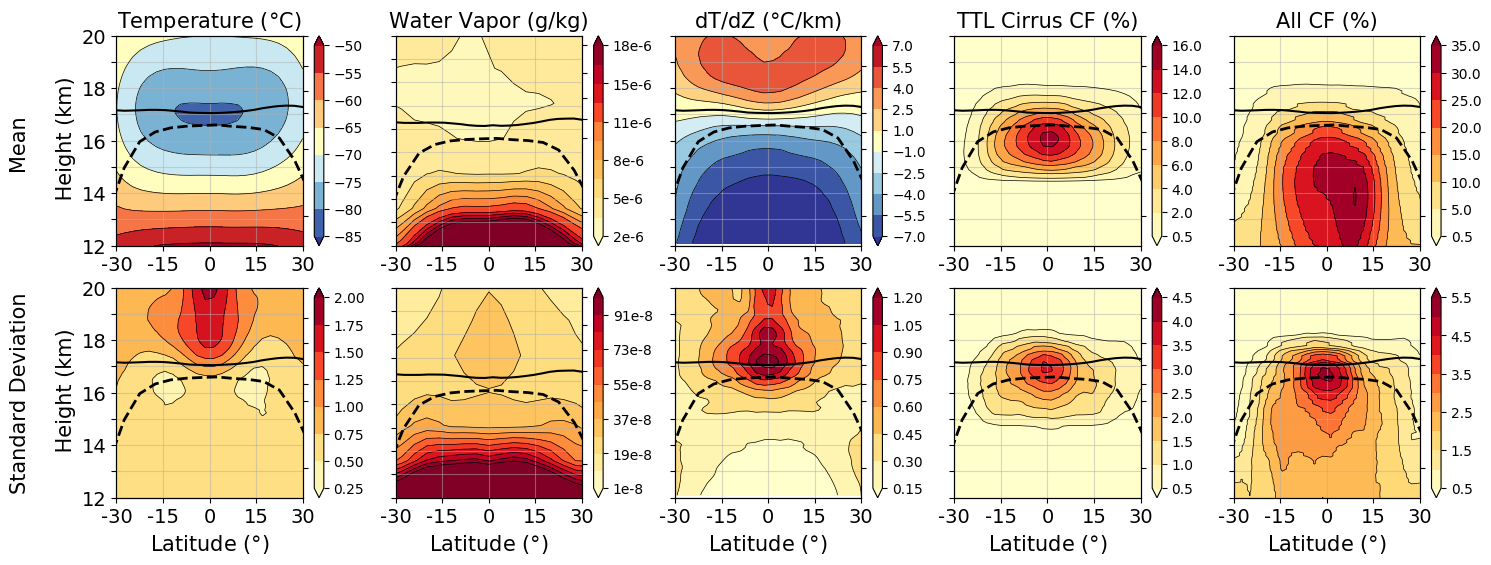

In [13]:
fig, axs = plt.subplots(2,5, figsize=(20,6))
temp_mean_levels = np.arange(-85,-45,5)
wv_mean_levels = np.array([2, 3.5, 5,6.5,8,9.5,11,13.5,15,16.5,18])*1e-6
dtdz_mean_levels = [-7,-5.5,-4,-2.5,-1,1,2.5,4,5.5,7]
ttlcf_mean_levels = np.array([0.5,2,4,6,8,10,12,14,16])
allcf_mean_levels = np.array([0.5,5,10,15,20,25,30,35])
cf_std_levels = np.array([.5,1,1.5,2,2.5,3,3.5,4,4.5])
t_std_levels = np.array([.25,.5,.75,1,1.25,1.5,1.75,2])
wv_std_levels = np.linspace(1e-8,1e-6, 12)
allcf_std_levels = np.array([0.5,1,1.5,2,2.5,3,3.5,4.,4.5,5,5.5])
dtdz_std_levels = [0.15,0.3,0.45,0.6,0.75,0.9,1.05,1.2]

h2o_pressures = [1000.0, 825.4042, 681.29205, 562.3413, 464.15887, 
                 383.11868, 316.22775, 261.01572, 215.44347, 177.82794, 
                 146.77992, 121.15276, 100.0, 82.54042, 68.1292, 56.23413, 
                 46.41589, 38.311867, 31.622776, 26.101572, 21.544348, 
                 17.782795, 14.677993, 12.115276, 10.0, 8.254042, 6.8129206, 
                 5.623413, 4.6415887, 3.8311868, 3.1622777, 2.6101573, 2.1544347, 
                 1.7782794, 1.4677993, 1.2115277, 1.0, 0.68129206, 0.4641589, 
                 0.31622776, 0.21544346, 0.14677992, 0.1, 0.046415888, 0.021544347, 
                 0.01, 0.004641589, 0.0021544348, 0.001, 0.0004641589, 0.00021544346, 
                 1e-04, 4.6415887e-05, 2.1544347e-05, 1e-05]

pressures_as_alts = press2alt(np.array(h2o_pressures))
alts_as_pressures = alt2pres(np.linspace(12,22,100))

cmap2_colors = np.array([(255,255,255), (215,250,253), (2,249,255), (63,191,254), (108,146,255), (147,107,255), (184,71,255), (217,37,255), (253,2,255)])/255
cmap2_cmap = LinearSegmentedColormap.from_list('cmap', cmap2_colors)


axs[0,0].set_ylabel('Mean \n\n Height (km)', fontsize=15)
axs[1,0].set_ylabel("Standard Deviation\n\n Height (km)", fontsize=15)

axs[0,0].set_title('Temperature ($\degree$C)', fontsize=15)
contour_t_mean = axs[0,0].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), temp_prof_zm_am.T, levels=temp_mean_levels, cmap='RdYlBu_r', extend='both')
axs[0,0].contour(np.linspace(-30,30,24), np.linspace(12,22,100), temp_prof_zm_am.T, levels=temp_mean_levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(temp_mean_levels >= 0, "-", "-"))
contour_t_std = axs[1,0].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), t_std_map, levels=t_std_levels, cmap='YlOrRd', extend='both')
axs[1,0].contour(np.linspace(-30,30,24), np.linspace(12,22,100), t_std_map, levels=t_std_levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(t_std_levels >= 0, "-", "-"))

axs[0,1].set_title('Water Vapor (g/kg)', fontsize=15)
contour_wv_mean = axs[0,1].contourf(np.linspace(-32,32,17), h2o_pressures[6:20],  wv_prof_zm_am, levels=wv_mean_levels, cmap='YlOrRd', extend='both')
axs[0,1].contour(np.linspace(-32,32,17), h2o_pressures[6:20], wv_prof_zm_am, levels=wv_mean_levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(wv_mean_levels >= 0, "-", "-"))
contour_wv_std = axs[1,1].contourf(np.linspace(-32,32,17), h2o_pressures[6:20], h2o_std_map.T, levels=wv_std_levels, cmap='YlOrRd', extend='both')
axs[1,1].contour(np.linspace(-32,32,17), h2o_pressures[6:20], h2o_std_map.T, levels=wv_std_levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(wv_std_levels >= 0, "-", "-"))

axs[0,2].set_title('dT/dZ ($\degree$C/km)', fontsize=15)
contour_dtdz_mean = axs[0,2].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), vert_temp_grad_profs_zm_am.T, levels=dtdz_mean_levels, cmap='RdYlBu_r', extend='both')
axs[0,2].contour(np.linspace(-30,30,24), np.linspace(12,22,100), vert_temp_grad_profs_zm_am.T, levels=dtdz_mean_levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(temp_mean_levels >= 0, "-", "-"))
contour_dtdz_std = axs[1,2].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), dtdz_std_map, levels=dtdz_std_levels, cmap='YlOrRd', extend='both')
axs[1,2].contour(np.linspace(-30,30,24), np.linspace(12,22,100), dtdz_std_map, levels=dtdz_std_levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(t_std_levels >= 0, "-", "-"))

axs[0,3].set_title("TTL Cirrus CF (%)", fontsize=15)
contour_ttlcf_mean = axs[0,3].contourf(np.linspace(-30,30,24), np.linspace(12,22,101), ttlcf_prof_zm_am.T*100, levels=ttlcf_mean_levels, cmap='YlOrRd', extend='both')
axs[0,3].contour(np.linspace(-30,30,24), np.linspace(12,22,101), ttlcf_prof_zm_am.T*100, levels=ttlcf_mean_levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(ttlcf_mean_levels >= 0, "-", "-"))
contour_ttlcf_std = axs[1,3].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), cf_std_map*100, levels=cf_std_levels, cmap='YlOrRd', extend='both')
axs[1,3].contour(np.linspace(-30,30,24), np.linspace(12,22,100), cf_std_map*100, levels=cf_std_levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(cf_std_levels >= 0, "-", "-"))

axs[0,4].set_title("All CF (%)", fontsize=15)
contour_allcf_mean = axs[0,4].contourf(np.linspace(-30,30,24), np.linspace(0,22,221), all_cf_am_zm.T*100, levels=allcf_mean_levels, cmap='YlOrRd', extend='both')
axs[0,4].contour(np.linspace(-30,30,24), np.linspace(0,22,221), all_cf_am_zm.T*100, levels=allcf_mean_levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(allcf_mean_levels >= 0, "-", "-"))
contour_allcf_std = axs[1,4].contourf(np.linspace(-30,30,24), np.linspace(0,22,221), all_std_map*100, levels=allcf_std_levels, cmap='YlOrRd', extend='both')
axs[1,4].contour(np.linspace(-30,30,24), np.linspace(0,22,221), all_std_map*100, levels=allcf_std_levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(allcf_std_levels >= 0, "-", "-"))

# Put pressure levels on height plots
for col in [0,2,3,4]:
    for row in range(2):
        axs[row,col].set_yticks([12,13,14,15,16,17,18,19,20,21])
        axs[row,col].set_xticks([-30,-15,0,15,30])
        axs[row,col].set_xticklabels(['-30','-15','0','15','30'], fontsize=14)
        naned_cyclic_cal = qbo_cf_rmap.copy()
        naned_cyclic_cal[:] = np.NaN
        ax2 = axs[row,col].twinx()
        ax2.contourf(np.linspace(-30,30,24), alts_as_pressures, naned_cyclic_cal)
        ax2.set_ylim(ax2.get_ylim()[::-1])
        ax2.set_yscale('log')
        ax2.set_ylim(180,57)
        ax2.set_yticks([150, 100, 90, 80, 70, 60, 50])
        if col == 0:
            axs[row,col].set_yticklabels(labels=['12',' ','14',' ','16',' ','18',' ','20', ' '], fontsize=14)
            ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' ', ' '], fontsize=14)
        elif col == 4:
            axs[row,col].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' ', ' '], fontsize=14)
            #ax2.set_yticklabels(labels=['150','100',' ',' ','70',' ', '50'], fontsize=14)
            ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' ', ' '], fontsize=14)
        else:
            axs[row,col].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ', ' '], fontsize=14)
            ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ', ' '], fontsize=14)
        axs[row,col].plot(np.linspace(-30,30,24), cpt_alts_zm, color='black', linewidth=1.5)
        axs[row, col].plot(np.linspace(-87.5,87.5,36)[11:25], lrz_maps_zm_annual_mean[11:25], color='black', linestyle='dashed', linewidth=2)

# Put height levels on pressure  plots
for row in range(2):
    naned_cyclic_cal = qbo_h2o_rmap.copy()
    naned_cyclic_cal[:] = np.NaN
    ax2 = axs[row,1].twinx()
    ax2.contourf(np.linspace(-32,32,17), pressures_as_alts[6:20], naned_cyclic_cal.T)
    ax2.set_ylim(12,20)
    ax2.set_xticks([-20,0,20])
    ax2.set_yticks([12,13,14,15,16,17,18,19,20,21])
    ax2.yaxis.tick_left()
    ax2.grid(alpha=0.5)
    #axs[row,1].set_yticks([150, 100, 90, 80, 70, 60, 50])
    #axs[row,1].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' '], fontsize=16)
    ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' ', ' '], fontsize=14)
    ax2.plot(np.linspace(-87.5,87.5,36)[11:25], lrz_maps_zm_annual_mean[11:25], color='black', linestyle='dashed', linewidth=2)


for row in range(0,2):
    for col in [0,2,3,4]:
        axs[row,col].set_ylim(12,20)
        axs[row,col].set_xlim(-30,30)
        axs[row,col].grid(alpha=0.5)

for row in range(0,2):
    axs[row,1].set_ylim(axs[row,1].get_ylim()[::-1])
    axs[row,1].set_xticks([-30,-15,0,15,30])
    axs[row,1].set_xticklabels(['-30','-15','0','15','30'], fontsize=14)
    axs[row,1].set_xlim(-30,30)
    axs[row,1].set_yscale('log')
    axs[row,1].yaxis.tick_right()
    axs[row,1].xaxis.grid(alpha=0.5)
    axs[row,1].set_yticks([150, 100, 90, 80, 70, 60, 50])
    axs[row,1].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' '], fontsize=16)
    axs[row,1].set_ylim(180,57)
    axs[row,1].plot(np.linspace(-30,30,24), cpt_pres_zm, color='black', linewidth=1.5)
    
fig.subplots_adjust(right=0.8)
contour_images = np.array([[contour_t_mean, contour_wv_mean, contour_dtdz_mean, contour_ttlcf_mean, contour_allcf_mean], 
                           [contour_t_std, contour_wv_std, contour_dtdz_std, contour_ttlcf_std, contour_allcf_std]])
for i in range(2):
    for j in range(5):
        im = contour_images[i,j]
        if j == 1:
            if i == 0:
                cbar = plt.colorbar(im, ax=axs[i, j],ticks=np.array([2,5,8,11,15,18])*1e-6)
                cbar.ax.set_yticklabels(['2e-6', '5e-6','8e-6','11e-6','15e-6','18e-6']) 
            elif i == 1:
                cbar = plt.colorbar(im, ax=axs[i, j],ticks=np.array([1, 19, 37, 55, 73, 91])*1e-8)
                cbar.ax.set_yticklabels(['1e-8', '19e-8','37e-8', '55e-8', '73e-8', '91e-8']) 
        else:
            plt.colorbar(im, ax=axs[i, j])
        axs[1,j].set_xlabel('Latitude ($\degree$)', fontsize=15)

#fig.subplots_adjust(bottom=0.2)
#cbar_cf = fig.add_axes([0.25, 0.12, 0.5, 0.03])
#fig.colorbar(cf_im, cax=cbar_cf, orientation='horizontal', ticks=[-.9, -.6,-.3,-.1,.1, .3,.6,.9])


In [14]:
temp_profs_zm = np.nanmean(temp_profs_TTL, axis=3)
vert_temp_grad_profs_zm = np.nanmean(vert_temp_grad_profs, axis=3)
profiles_cf_zm = np.nanmean(profiles_cf, axis=3)
profile_all_cf_zm = np.nanmean(profile_all_cf_cal, axis=3)
wv_anoms_zm = wv_anoms_zm_ts

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [15]:
def seasonal_split_climatological_mean_and_variance(data_calendar):

    data_calendar_anoms = data_calendar - np.nanmean(data_calendar, axis=0)

    bw_cal = [data_calendar[:,10], data_calendar[:,11], data_calendar[:,0], 
              data_calendar[:,1], data_calendar[:,2]]
    bs_cal = [data_calendar[:,4], data_calendar[:,5], data_calendar[:,6], 
              data_calendar[:,7], data_calendar[:,8]]
    bw_cal_anoms = [data_calendar_anoms[:,10], data_calendar_anoms[:,11], data_calendar_anoms[:,0], 
                    data_calendar_anoms[:,1], data_calendar_anoms[:,2]]
    bs_cal_anoms = [data_calendar_anoms[:,4], data_calendar_anoms[:,5], data_calendar_anoms[:,6], 
                    data_calendar_anoms[:,7], data_calendar_anoms[:,8]]
    
    bw_cal_shape = np.shape(bw_cal)
    bs_cal_shape = np.shape(bs_cal)
    
    bw_mean = np.nanmean(np.reshape(bw_cal, (bw_cal_shape[0]*bw_cal_shape[1], bw_cal_shape[2], bw_cal_shape[3])), axis=0)
    bs_mean = np.nanmean(np.reshape(bs_cal, (bs_cal_shape[0]*bs_cal_shape[1], bs_cal_shape[2], bs_cal_shape[3])), axis=0)
    

    bw_std = np.nanstd(np.reshape(bw_cal_anoms, (bw_cal_shape[0]*bw_cal_shape[1], bw_cal_shape[2], bw_cal_shape[3])), axis=0)
    bs_std = np.nanstd(np.reshape(bs_cal_anoms, (bs_cal_shape[0]*bs_cal_shape[1], bs_cal_shape[2], bs_cal_shape[3])), axis=0)

    return(bw_mean, bw_std, bs_mean, bs_std)

wv_bw_mean, wv_bw_std, wv_bs_mean, wv_bs_std = seasonal_split_climatological_mean_and_variance(wv_anoms_zm)
temp_bw_mean, temp_bw_std, temp_bs_mean, temp_bs_std = seasonal_split_climatological_mean_and_variance(temp_profs_zm)
ttlcf_bw_mean, ttlcf_bw_std, ttlcf_bs_mean, ttlcf_bs_std = seasonal_split_climatological_mean_and_variance(profiles_cf_zm)
dtdz_bw_mean, dtdz_bw_std, dtdz_bs_mean, dtdz_bs_std = seasonal_split_climatological_mean_and_variance(vert_temp_grad_profs_zm)
allcf_bw_mean, allcf_bw_std, allcf_bs_mean, allcf_bs_std = seasonal_split_climatological_mean_and_variance(profile_all_cf_zm)

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [16]:
cpt_alts_zm = np.nanmean(np.reshape(cpt_alts, (192,24,144)), axis=2)
cpt_pres_zm = np.reshape(np.load(project_path + '/tempmaps/calendar_of_cpt_pressures_zm.npy'), (180,24))
cpt_alt_cal = np.reshape(cpt_alts_zm, (16,12,24))
cpt_pres_cal = np.reshape(cpt_pres_zm, (15,12,24))


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


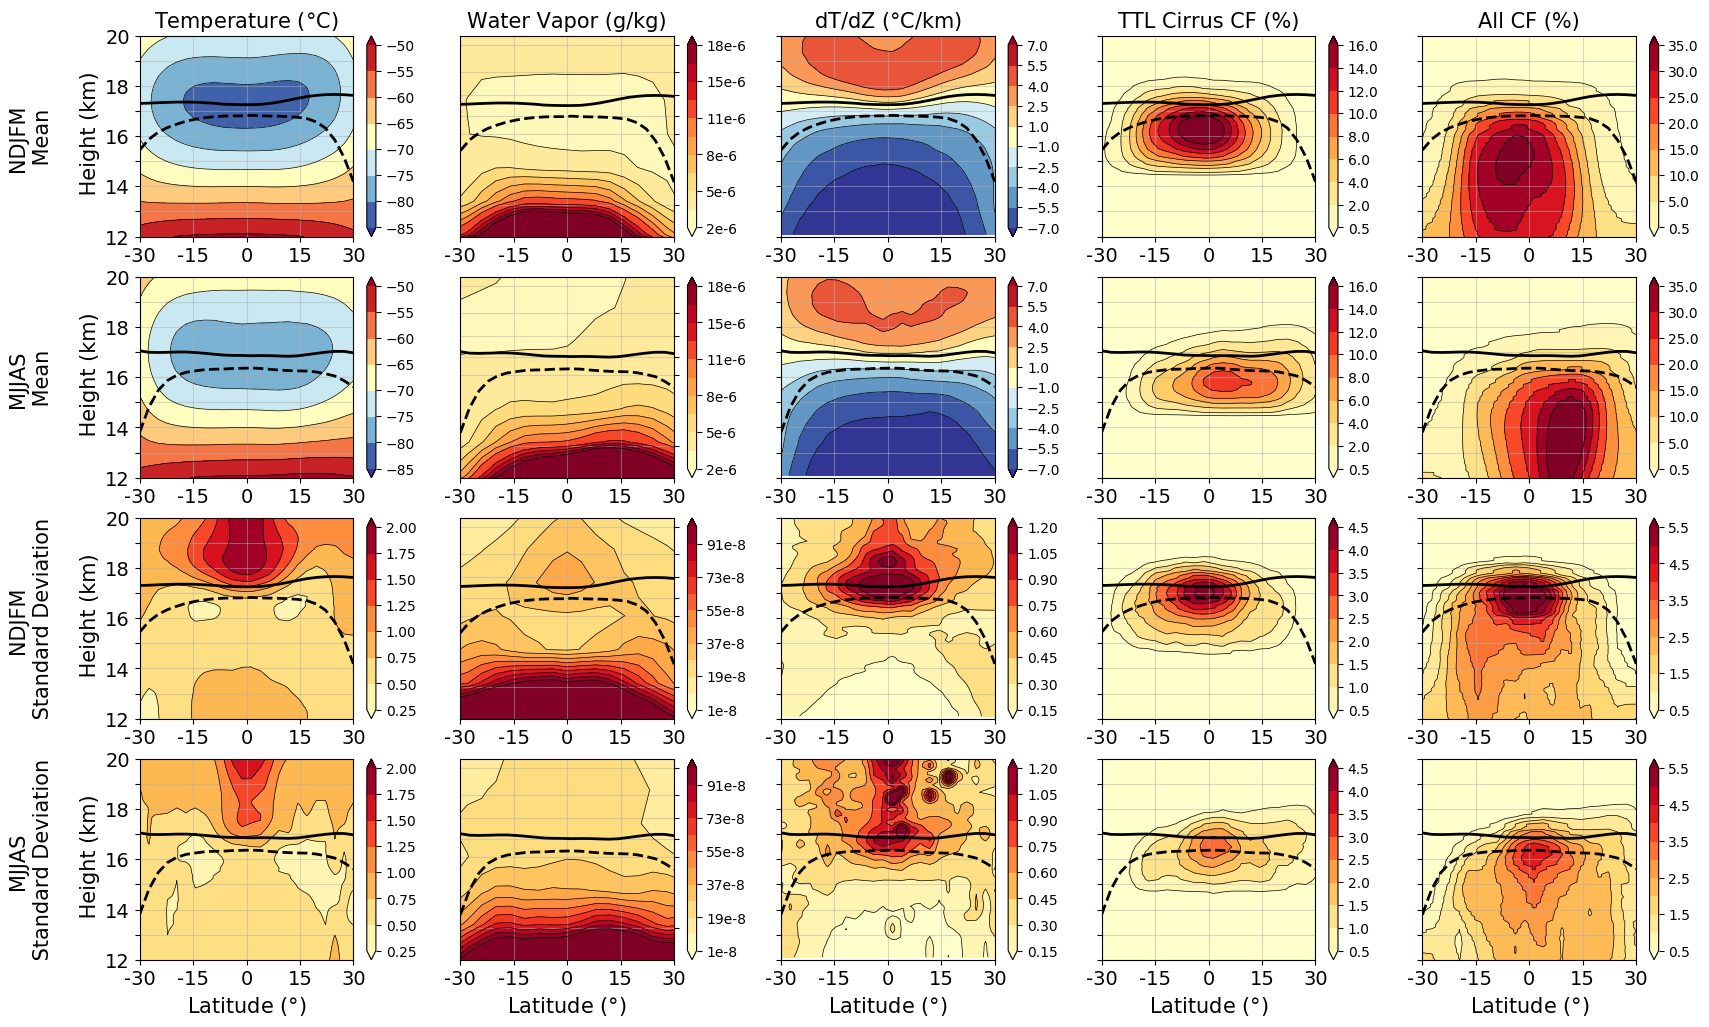

In [18]:
lats = np.linspace(-30,30,24)
temp_z = np.linspace(12,22,100)
ttlcf_z = np.linspace(12,22,101)
allcf_z = np.linspace(0,22,221)
wv_lats = np.linspace(-32,32,17)
wv_pressures = h2o_pressures[6:20]

LRT_files = np.sort(glob.glob('/home/disk/p/aodhan/cf_physical_parameters_correlations/tempmaps/lrtmaps_*_c1mamb.npy'))
LRT = [np.load(LRT_files[i]) for i in range(len(LRT_files))]
LRZ_zm_climatology = np.nanmean(np.nanmean(LRT, axis=3)[:,:,:,1], axis=0)
bw_lrz = np.nanmean([LRZ_zm_climatology[0], LRZ_zm_climatology[1], LRZ_zm_climatology[2], LRZ_zm_climatology[10], LRZ_zm_climatology[11]], axis=0)
bs_lrz = np.nanmean([LRZ_zm_climatology[4], LRZ_zm_climatology[5], LRZ_zm_climatology[6], LRZ_zm_climatology[7], LRZ_zm_climatology[8]], axis=0)
bw_lrp = alt2pres(bw_lrz)
bs_lrp = alt2pres(bs_lrz)


temp_mean_levels = np.arange(-85,-45,5)
wv_mean_levels = np.array([2, 3.5, 5,6.5,8,9.5,11,13.5,15,16.5,18])*1e-6
dtdz_mean_levels = np.array([-7,-5.5,-4,-2.5,-1,1,2.5,4,5.5,7])
ttlcf_mean_levels = np.array([0.5,2,4,6,8,10,12,14,16])
allcf_mean_levels = np.array([0.5,5,10,15,20,25,30,35])
cf_std_levels = np.array([.5,1,1.5,2,2.5,3,3.5,4,4.5])
t_std_levels = np.array([.25,.5,.75,1,1.25,1.5,1.75,2])
wv_std_levels = np.linspace(1e-8,1e-6, 12)
allcf_std_levels = np.array([0.5,1,1.5,2,2.5,3,3.5,4.,4.5,5,5.5])
dtdz_std_levels = np.array([0.15,0.3,0.45,0.6,0.75,0.9,1.05,1.2])

fig, axs = plt.subplots(4,5, figsize=(20,12))
bw_means = [temp_bw_mean, wv_bw_mean, dtdz_bw_mean, ttlcf_bw_mean, allcf_bw_mean]
bw_stds = [temp_bw_std, wv_bw_std, dtdz_bw_std, ttlcf_bw_std, allcf_bw_std]
bs_means = [temp_bs_mean, wv_bs_mean, dtdz_bs_mean, ttlcf_bs_mean, allcf_bs_mean]
bs_stds = [temp_bs_std, wv_bs_std, dtdz_bs_std, ttlcf_bs_std, allcf_bs_std]
mean_lvls = [temp_mean_levels, wv_mean_levels, dtdz_mean_levels, ttlcf_mean_levels, allcf_mean_levels]
std_lvls = [t_std_levels, wv_std_levels, dtdz_std_levels, cf_std_levels, allcf_std_levels]
mean_std_season_array = [bw_means, bs_means, bw_stds, bs_stds]
mean_std_levels = [mean_lvls, mean_lvls, std_lvls, std_lvls]
bw_cpt_alt = np.nanmean(np.reshape([cpt_alt_cal[:,10],cpt_alt_cal[:,11],cpt_alt_cal[:,0],cpt_alt_cal[:,1],cpt_alt_cal[:,2]], (16*5,24)), axis=0)
bw_cpt_press = np.nanmean(np.reshape([cpt_pres_cal[:,10],cpt_pres_cal[:,11],cpt_pres_cal[:,0],cpt_pres_cal[:,1],cpt_pres_cal[:,2]], (15*5,24)), axis=0)
bs_cpt_alt = np.nanmean(np.reshape([cpt_alt_cal[:,4],cpt_alt_cal[:,5],cpt_alt_cal[:,6],cpt_alt_cal[:,7],cpt_alt_cal[:,8]], (16*5,24)), axis=0)
bs_cpt_press = np.nanmean(np.reshape([cpt_pres_cal[:,4],cpt_pres_cal[:,5],cpt_pres_cal[:,6],cpt_pres_cal[:,7],cpt_pres_cal[:,8]], (15*5,24)), axis=0)
bw_cpt_rows = [bw_cpt_alt, bw_cpt_press, bw_cpt_alt, bw_cpt_alt, bw_cpt_alt]
bs_cpt_rows = [bs_cpt_alt, bs_cpt_press, bs_cpt_alt, bs_cpt_alt, bs_cpt_alt]
cpt_rows = [bw_cpt_alt, bs_cpt_alt, bw_cpt_alt, bs_cpt_alt]
lrz_rows = [bw_lrz, bs_lrz, bw_lrz, bs_lrz]
bw_cpp = alt2pres(bw_cpt_alt)
bs_cpp = alt2pres(bs_cpt_alt)
cpt_pres_rows = [bw_cpp, bs_cpp, bw_cpp, bs_cpp]
lrp_rows = [bw_lrp, bs_lrp, bw_lrp, bs_lrp]

contour_images = []
for row in range(4):
    contour_images_row = []
    cptz_data = cpt_rows[row][col]
    for col in range(5):
        data = mean_std_season_array[row][col]
        levels = mean_std_levels[row][col]
        axs[row,col].xaxis.grid(alpha=0.5)
        axs[row,col].set_yticks([12,13,14,15,16,17,18,19,20,21])
        axs[row,col].set_xticks([-30,-15,0,15,30])
        axs[row,col].set_xticklabels(['-30','-15','0','15','30'], fontsize=14)
        axs[row,col].yaxis.grid(alpha=0.5)
        if col == 0:
            axs[row,col].set_yticklabels(labels=['12',' ','14',' ','16',' ','18',' ','20', ' '], fontsize=14)
            im = axs[row,col].contourf(lats, temp_z, data.T, levels=levels, cmap='YlOrRd', extend='both')
            axs[row,col].contour(lats, temp_z, data.T, levels=levels, colors='black', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
            axs[row,col].set_ylim(12,20)
            axs[row,col].plot(np.linspace(-30,30,24), cpt_rows[row], color='black', linewidth=2)
            axs[row,col].plot(np.linspace(-30,30,24), lrz_rows[row], color='black', linewidth=2, linestyle='dashed')
            if row == 0:
                im = axs[row,col].contourf(lats, temp_z, data.T, levels=levels, cmap='RdYlBu_r', extend='both')
                axs[row,col].set_title('Temperature ($\degree$C)', fontsize=15)
                axs[row,col].set_ylabel('NDJFM \n Mean \n\n Height (km)', fontsize=15)
            if row == 1:
                im = axs[row,col].contourf(lats, temp_z, data.T, levels=levels, cmap='RdYlBu_r', extend='both')
                axs[row,col].set_ylabel('MJJAS \n Mean \n\n Height (km)', fontsize=15)
            if row == 2:
                axs[row,col].set_ylabel('NDJFM \n Standard Deviation \n\n Height (km)', fontsize=15)
            if row == 3:
                axs[row,col].set_ylabel('MJJAS \n Standard Deviation \n\n Height (km)', fontsize=15)
        if col == 1:
            im = axs[row,col].contourf(wv_lats, wv_pressures, data, levels=levels, cmap='YlOrRd', extend='both')
            axs[row,col].contour(wv_lats, wv_pressures, data, levels=levels, colors='black', linewidths=0.5, 
            linestyles=np.where(levels >= 0, "-", "-"))
            axs[row,col].set_ylim(axs[row,col].get_ylim()[::-1])
            axs[row,col].set_yscale('log')
            axs[row,col].yaxis.tick_right()
            axs[row,col].set_xticks([-30,-15,0,15,30])
            axs[row,col].set_xlim(-30,30)
            axs[row,1].set_yticks([150, 100, 90, 80, 70, 60, 50])
            axs[row,1].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' '], fontsize=16)
            axs[row,col].set_ylim(180,57)
            axs[row,1].plot(np.linspace(-30,30,24), cpt_pres_rows[row], color='black', linewidth=2)
            axs[row,1].plot(np.linspace(-30,30,24), lrp_rows[row], color='black', linewidth=2, linestyle='dashed')
            if row == 0:
                axs[row,col].set_title('Water Vapor (g/kg)', fontsize=15)
        if col == 2:
            axs[row,col].set_yticks([12,13,14,15,16,17,18,19,20,21])
            axs[row,col].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=16)
            axs[row,col].plot(np.linspace(-30,30,24), cpt_rows[row], color='black', linewidth=2)
            axs[row,col].plot(np.linspace(-30,30,24), lrz_rows[row], color='black', linewidth=2, linestyle='dashed')
            if (row == 0) or (row == 1):
                im = axs[row,col].contourf(lats, temp_z, data.T, levels=levels, cmap='RdYlBu_r', extend='both')
            else:
                im = axs[row,col].contourf(lats, temp_z, data.T, levels=levels, cmap='YlOrRd', extend='both')
            axs[row,col].contour(lats, temp_z, data.T, levels=levels, colors='black', linewidths=0.5, 
            linestyles=np.where(levels >= 0, "-", "-"))
            axs[row,col].set_ylim(12,20)
            if row == 0:
                axs[row,col].set_title('dT/dZ ($\degree$C/km)', fontsize=15)
        if col == 3:
            im = axs[row,col].contourf(lats, ttlcf_z, data.T*100, levels=levels, cmap='YlOrRd', extend='both')
            axs[row,col].contour(lats, ttlcf_z, data.T*100, levels=levels, colors='black', linewidths=0.5, 
            linestyles=np.where(levels >= 0, "-", "-"))
            axs[row,col].plot(np.linspace(-30,30,24), cpt_rows[row], color='black', linewidth=2)
            axs[row,col].plot(np.linspace(-30,30,24), lrz_rows[row], color='black', linewidth=2, linestyle='dashed')
            axs[row,col].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=16)
            axs[row,col].set_ylim(12,20)
            if row == 0:
                axs[row,col].set_title('TTL Cirrus CF (%)', fontsize=15)
        if col == 4:
            im = axs[row,col].contourf(lats, allcf_z, data.T*100, levels=levels, cmap='YlOrRd', extend='both')
            axs[row,col].contour(lats, allcf_z, data.T*100, levels=levels, colors='black', linewidths=0.5, 
            linestyles=np.where(levels >= 0, "-", "-"))
            axs[row,col].plot(np.linspace(-30,30,24), cpt_rows[row], color='black', linewidth=2)
            axs[row,col].plot(np.linspace(-30,30,24), lrz_rows[row], color='black', linewidth=2, linestyle='dashed')
            axs[row,col].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=16)
            axs[row,col].set_ylim(12,20)
            if row == 0:
                axs[row,col].set_title('All CF (%)', fontsize=15)
        #axs[row,col].plot(lats, cptz_data, color='white', linewidth=1.5)
        contour_images_row.append(im)
    contour_images.append(contour_images_row)

for i in range(4):
    for j in range(5):
        axs[3,j].set_xlabel('Latitude ($\degree$)', fontsize=15)
        im = contour_images[i][j]
        if j == 1:
            if i < 2:
                cbar = plt.colorbar(im, ax=axs[i, j],ticks=np.array([2,5,8,11,15,18])*1e-6)
                cbar.ax.set_yticklabels(['2e-6', '5e-6','8e-6','11e-6','15e-6','18e-6']) 
            elif i >= 2:
                cbar = plt.colorbar(im, ax=axs[i, j],ticks=np.array([1, 19, 37, 55, 73, 91])*1e-8)
                cbar.ax.set_yticklabels(['1e-8', '19e-8','37e-8', '55e-8', '73e-8', '91e-8']) 
        else:
            plt.colorbar(im, ax=axs[i, j])

/home/disk/p/aodhan/.local/lib/python3.7/site-packages/matplotlib/contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/disk/p/aodhan/.local/lib/python3.7/site-packages/matplotlib/contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


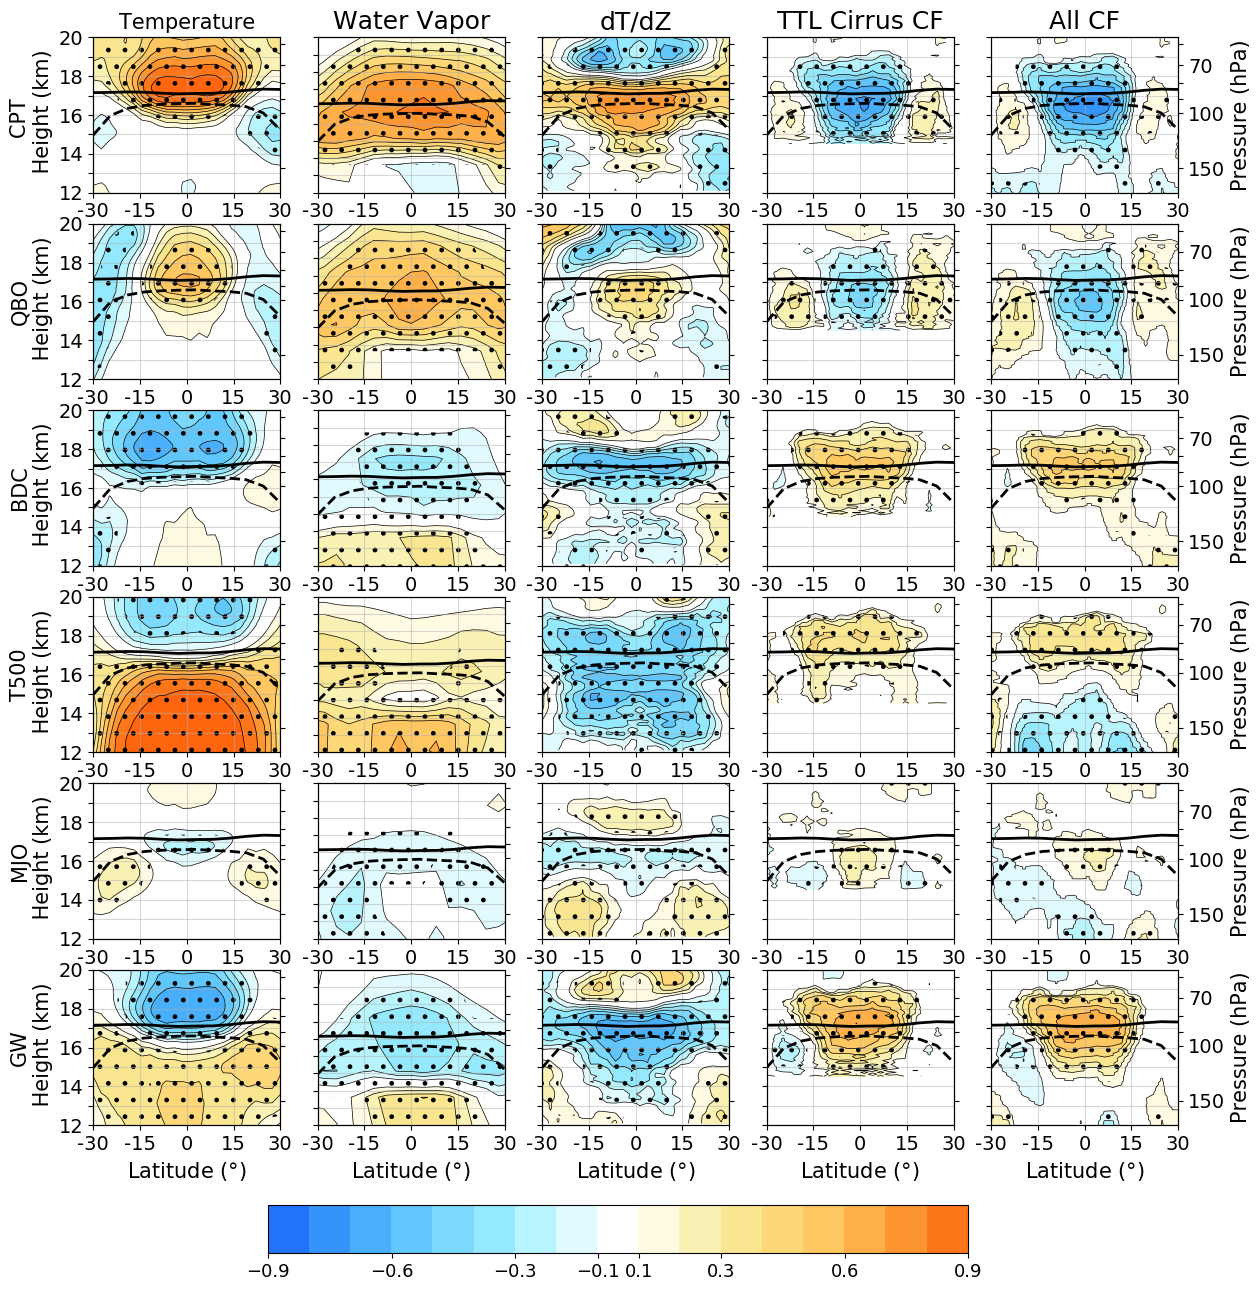

In [30]:
fig, axs = plt.subplots(6,5, figsize=(14,16))
levels = np.array([-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9])/10
cf_std_levels = np.array([.5,1,1.5,2,2.5,3,3.5,4,4.5])
t_std_levels = np.array([.25,.5,.75,1,1.25,1.5,1.75,2,2.25])

h2o_pressures = [1000.0, 825.4042, 681.29205, 562.3413, 464.15887, 
                 383.11868, 316.22775, 261.01572, 215.44347, 177.82794, 
                 146.77992, 121.15276, 100.0, 82.54042, 68.1292, 56.23413, 
                 46.41589, 38.311867, 31.622776, 26.101572, 21.544348, 
                 17.782795, 14.677993, 12.115276, 10.0, 8.254042, 6.8129206, 
                 5.623413, 4.6415887, 3.8311868, 3.1622777, 2.6101573, 2.1544347, 
                 1.7782794, 1.4677993, 1.2115277, 1.0, 0.68129206, 0.4641589, 
                 0.31622776, 0.21544346, 0.14677992, 0.1, 0.046415888, 0.021544347, 
                 0.01, 0.004641589, 0.0021544348, 0.001, 0.0004641589, 0.00021544346, 
                 1e-04, 4.6415887e-05, 2.1544347e-05, 1e-05]
h2o_pressures = h2o_pressures[6:20]

pressures_as_alts = press2alt(np.array(h2o_pressures))
alts_as_pressures = alt2pres(np.linspace(12,22,100))
levels_cf =levels
levels_h2o = levels

axs[0,0].set_ylabel('CPT \n Height (km)', fontsize=15)
axs[1,0].set_ylabel('QBO\n Height (km)', fontsize=15)
axs[2,0].set_ylabel('BDC\n Height (km)', fontsize=15)
axs[3,0].set_ylabel('T500\n Height (km)', fontsize=15)
axs[4,0].set_ylabel('MJO\n Height (km)', fontsize=15)
axs[5,0].set_ylabel('GW\n Height (km)', fontsize=15)


axs[0,0].set_title("Temperature", fontsize=15)
axs[0,0].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), cpt_t_rmap, levels=levels, cmap=custom_cmap, extend='both')
axs[0,0].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), cpt_t_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[0,0].contour(np.linspace(-30,30,24), np.linspace(12,22,100), cpt_t_rmap, levels=levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels >= 0, "-", "-"))
axs[1,0].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), qbo_t_rmap, levels=levels, cmap=custom_cmap, extend='both')
axs[1,0].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), qbo_t_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[1,0].contour(np.linspace(-30,30,24), np.linspace(12,22,100), qbo_t_rmap, levels=levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels >= 0, "-", "-"))
axs[2,0].contourf(np.linspace(-30,30,24), np.linspace(12.,22,100), bdc_t_rmap, levels=levels, cmap=custom_cmap, extend='both')
axs[2,0].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), bdc_t_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[2,0].contour(np.linspace(-30,30,24), np.linspace(12,22,100), bdc_t_rmap, levels=levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels >= 0, "-", "-"))
temp_im = axs[3,0].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), enso_t_rmap, levels=levels, cmap=custom_cmap, extend='both')
axs[3,0].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), enso_t_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[3,0].contour(np.linspace(-30,30,24), np.linspace(12,22,100), enso_t_rmap, levels=levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels >= 0, "-", "-"))
axs[4,0].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), mjo_t_rmap, levels=levels, cmap=custom_cmap, extend='both')
axs[4,0].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), mjo_t_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[4,0].contour(np.linspace(-30,30,24), np.linspace(12,22,100), mjo_t_rmap, levels=levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels >= 0, "-", "-"))
axs[5,0].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), gw_t_rmap, levels=levels, cmap=custom_cmap, extend='both')
axs[5,0].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), gw_t_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[5,0].contour(np.linspace(-30,30,24), np.linspace(12,22,100), gw_t_rmap, levels=levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels >= 0, "-", "-"))

axs[0,1].set_title("Water Vapor", fontsize=18)
axs[0,1].contourf(np.linspace(-32,32,17), h2o_pressures, cpt_h2o_rmap.T, levels=levels_h2o, cmap=custom_cmap, extend='both')
axs[0,1].contourf(np.linspace(-32,32,17), h2o_pressures, cpt_h2o_sigmap.T, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[0,1].contour(np.linspace(-32,32,17), h2o_pressures, cpt_h2o_rmap.T, levels=levels_h2o, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_h2o >= 0, "-", "-"))
axs[1,1].contourf(np.linspace(-32,32,17), h2o_pressures, qbo_h2o_rmap.T, levels=levels_h2o, cmap=custom_cmap, extend='both')
axs[1,1].contourf(np.linspace(-32,32,17), h2o_pressures, qbo_h2o_sigmap.T, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[1,1].contour(np.linspace(-32,32,17), h2o_pressures, qbo_h2o_rmap.T, levels=levels_h2o, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_h2o >= 0, "-", "-"))
axs[2,1].contourf(np.linspace(-32,32,17), h2o_pressures, bdc_h2o_rmap.T, levels=levels_h2o, cmap=custom_cmap, extend='both')
axs[2,1].contourf(np.linspace(-32,32,17), h2o_pressures, bdc_h2o_sigmap.T, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[2,1].contour(np.linspace(-32,32,17), h2o_pressures, bdc_h2o_rmap.T, levels=levels_h2o, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_h2o >= 0, "-", "-"))
axs[3,1].contourf(np.linspace(-32,32,17), h2o_pressures, enso_h2o_rmap.T, levels=levels_h2o, cmap=custom_cmap)
axs[3,1].contourf(np.linspace(-32,32,17), h2o_pressures, enso_h2o_sigmap.T, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[3,1].contour(np.linspace(-32,32,17), h2o_pressures, enso_h2o_rmap.T, levels=levels_h2o, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_h2o >= 0, "-", "-"))
axs[4,1].contourf(np.linspace(-32,32,17), h2o_pressures, mjo_h2o_rmap.T, levels=levels_h2o, cmap=custom_cmap)
axs[4,1].contourf(np.linspace(-32,32,17), h2o_pressures, mjo_h2o_sigmap.T, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[4,1].contour(np.linspace(-32,32,17), h2o_pressures, mjo_h2o_rmap.T, levels=levels_h2o, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_h2o >= 0, "-", "-"))
axs[5,1].contourf(np.linspace(-32,32,17), h2o_pressures, gw_h2o_rmap.T, levels=levels_h2o, cmap=custom_cmap)
axs[5,1].contourf(np.linspace(-32,32,17), h2o_pressures, gw_h2o_sigmap.T, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[5,1].contour(np.linspace(-32,32,17), h2o_pressures, gw_h2o_rmap.T, levels=levels_h2o, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_h2o >= 0, "-", "-"))


axs[0,2].set_title("dT/dZ", fontsize=18)
axs[0,2].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), cpt_dtdz_rmap, levels=levels, cmap=custom_cmap, extend='both')
axs[0,2].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), cpt_dtdz_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[0,2].contour(np.linspace(-30,30,24), np.linspace(12,22,100), cpt_dtdz_rmap, levels=levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels >= 0, "-", "-"))
axs[1,2].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), qbo_dtdz_rmap, levels=levels, cmap=custom_cmap, extend='both')
axs[1,2].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), qbo_dtdz_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[1,2].contour(np.linspace(-30,30,24), np.linspace(12,22,100), qbo_dtdz_rmap, levels=levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels >= 0, "-", "-"))
axs[2,2].contourf(np.linspace(-30,30,24), np.linspace(12.,22,100), bdc_dtdz_rmap, levels=levels, cmap=custom_cmap, extend='both')
axs[2,2].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), bdc_dtdz_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[2,2].contour(np.linspace(-30,30,24), np.linspace(12,22,100), bdc_dtdz_rmap, levels=levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels >= 0, "-", "-"))
temp_im = axs[3,2].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), enso_dtdz_rmap, levels=levels, cmap=custom_cmap, extend='both')
axs[3,2].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), enso_dtdz_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[3,2].contour(np.linspace(-30,30,24), np.linspace(12,22,100), enso_dtdz_rmap, levels=levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels >= 0, "-", "-"))
axs[4,2].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), mjo_dtdz_rmap, levels=levels, cmap=custom_cmap, extend='both')
axs[4,2].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), mjo_dtdz_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[4,2].contour(np.linspace(-30,30,24), np.linspace(12,22,100), mjo_dtdz_rmap, levels=levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels >= 0, "-", "-"))
axs[5,2].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), gw_dtdz_rmap, levels=levels, cmap=custom_cmap, extend='both')
axs[5,2].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), gw_dtdz_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[5,2].contour(np.linspace(-30,30,24), np.linspace(12,22,100), gw_dtdz_rmap, levels=levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels >= 0, "-", "-"))


axs[0,3].set_title("TTL Cirrus CF", fontsize=18)
axs[0,3].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), cpt_cf_rmap, levels=levels_cf, cmap=custom_cmap, extend='both')
axs[0,3].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), cpt_cf_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[0,3].contour(np.linspace(-30,30,24), np.linspace(12,22,100), cpt_cf_rmap, levels=levels_cf, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_cf >= 0, "-", "-"))
axs[1,3].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), qbo_cf_rmap, levels=levels_cf, cmap=custom_cmap, extend='both')
axs[1,3].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), qbo_cf_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[1,3].contour(np.linspace(-30,30,24), np.linspace(12,22,100), qbo_cf_rmap, levels=levels_cf, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_cf >= 0, "-", "-"))
axs[2,3].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), bdc_cf_rmap, levels=levels_cf, cmap=custom_cmap, extend='both')
axs[2,3].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), bdc_cf_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[2,3].contour(np.linspace(-30,30,24), np.linspace(12,22,100), bdc_cf_rmap, levels=levels_cf, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_cf >= 0, "-", "-"))
cf_im = axs[3,3].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), enso_cf_rmap, levels=levels_cf, cmap=custom_cmap)
axs[3,3].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), enso_cf_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[3,3].contour(np.linspace(-30,30,24), np.linspace(12,22,100), enso_cf_rmap, levels=levels_cf, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_cf >= 0, "-", "-"))
axs[4,3].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), mjo_cf_rmap, levels=levels_cf, cmap=custom_cmap)
axs[4,3].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), mjo_cf_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[4,3].contour(np.linspace(-30,30,24), np.linspace(12,22,100), mjo_cf_rmap, levels=levels_cf, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_cf >= 0, "-", "-"))
axs[5,3].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), gw_cf_rmap, levels=levels_cf, cmap=custom_cmap)
axs[5,3].contourf(np.linspace(-30,30,24), np.linspace(12,22,100), gw_cf_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[5,3].contour(np.linspace(-30,30,24), np.linspace(12,22,100), gw_cf_rmap, levels=levels_cf, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_cf >= 0, "-", "-"))



axs[0,4].set_title("All CF", fontsize=18)
axs[0,4].contourf(np.linspace(-30,30,24), np.linspace(0,22,221), cpt_all_rmap, levels=levels_cf, cmap=custom_cmap, extend='both')
axs[0,4].contourf(np.linspace(-30,30,24), np.linspace(0,22,221), cpt_all_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[0,4].contour(np.linspace(-30,30,24), np.linspace(0,22,221), cpt_all_rmap, levels=levels_cf, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_cf >= 0, "-", "-"))
axs[1,4].contourf(np.linspace(-30,30,24), np.linspace(0,22,221), qbo_all_rmap, levels=levels_cf, cmap=custom_cmap, extend='both')
axs[1,4].contourf(np.linspace(-30,30,24), np.linspace(0,22,221), qbo_all_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[1,4].contour(np.linspace(-30,30,24), np.linspace(0,22,221), qbo_all_rmap, levels=levels_cf, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_cf >= 0, "-", "-"))
axs[2,4].contourf(np.linspace(-30,30,24), np.linspace(0,22,221), bdc_all_rmap, levels=levels_cf, cmap=custom_cmap, extend='both')
axs[2,4].contourf(np.linspace(-30,30,24), np.linspace(0,22,221), bdc_all_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[2,4].contour(np.linspace(-30,30,24), np.linspace(0,22,221), bdc_all_rmap, levels=levels_cf, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_cf >= 0, "-", "-"))
cf_im = axs[3,4].contourf(np.linspace(-30,30,24), np.linspace(0,22,221), enso_all_rmap, levels=levels_cf, cmap=custom_cmap)
axs[3,4].contourf(np.linspace(-30,30,24), np.linspace(0,22,221), enso_all_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[3,4].contour(np.linspace(-30,30,24), np.linspace(0,22,221), enso_all_rmap, levels=levels_cf, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_cf >= 0, "-", "-"))
axs[4,4].contourf(np.linspace(-30,30,24), np.linspace(0,22,221), mjo_all_rmap, levels=levels_cf, cmap=custom_cmap)
axs[4,4].contourf(np.linspace(-30,30,24), np.linspace(0,22,221), mjo_all_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[4,4].contour(np.linspace(-30,30,24), np.linspace(0,22,221), mjo_all_rmap, levels=levels_cf, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_cf >= 0, "-", "-"))
axs[5,4].contourf(np.linspace(-30,30,24), np.linspace(0,22,221), gw_all_rmap, levels=levels_cf, cmap=custom_cmap)
axs[5,4].contourf(np.linspace(-30,30,24), np.linspace(0,22,221), gw_all_sigmap, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
axs[5,4].contour(np.linspace(-30,30,24), np.linspace(0,22,221), gw_all_rmap, levels=levels_cf, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_cf >= 0, "-", "-"))


# Put pressure levels on height plots
for col in [0,2,3,4]:
    for row in range(6):
        axs[row,col].set_yticks([12,13,14,15,16,17,18,19,20,21])
        axs[row,col].set_xticks([-30,-15,0,15,30])
        axs[row,col].set_xticklabels(['-30','-15','0','15','30'], fontsize=14)
        naned_cyclic_cal = qbo_cf_rmap.copy()
        naned_cyclic_cal[:] = np.NaN
        ax2 = axs[row,col].twinx()
        ax2.contourf(np.linspace(-30,30,24), alts_as_pressures, naned_cyclic_cal)
        ax2.set_ylim(ax2.get_ylim()[::-1])
        ax2.set_yscale('log')
        ax2.set_yticks([150, 100, 90, 80, 70, 60, 50])
        if col == 0:
            axs[row,col].set_yticklabels(labels=['12',' ','14',' ','16',' ','18',' ','20', ' '], fontsize=14)
            ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' ', ' '], fontsize=14)
        elif col == 4:
            axs[row,col].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' ', ' '], fontsize=14)
            ax2.set_yticklabels(labels=['150','100',' ',' ','70',' ', '50'], fontsize=14)
            ax2.set_ylabel('Pressure (hPa)', fontsize=15)
        else:
            axs[row,col].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ', ' '], fontsize=14)
            ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ', ' '], fontsize=14)
        axs[row,col].plot(np.linspace(-30,30,12), lrz_maps_zm_annual_mean[12:24], color='black', linewidth=2, linestyle='dashed')
        axs[row,col].plot(np.linspace(-30,30,12), cpz_maps_zm_annual_mean[12:24], color='black', linewidth=2)
        ax2.set_ylim(180,57)

# Put height levels on pressure  plots
for row in range(6):
    naned_cyclic_cal = qbo_h2o_rmap.copy()
    naned_cyclic_cal[:] = np.NaN
    ax2 = axs[row,1].twinx()
    ax2.contourf(np.linspace(-32,32,17), pressures_as_alts, naned_cyclic_cal.T)
    ax2.set_ylim(12,20)
    ax2.set_xticks([-20,0,20])
    ax2.set_yticks([12,13,14,15,16,17,18,19,20,21])
    ax2.yaxis.tick_left()
    ax2.grid(alpha=0.5)
    #axs[row,1].set_yticks([150, 100, 90, 80, 70, 60, 50])
    #axs[row,1].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' '], fontsize=16)
    ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' ', ' '], fontsize=14)
    ax2.plot(np.linspace(-30,30,12), lrz_maps_zm_annual_mean[12:24], color='black', linewidth=2, linestyle='dashed')
    ax2.plot(np.linspace(-30,30,12), cpz_maps_zm_annual_mean[12:24], color='black', linewidth=2)

for row in range(6):
    for col in [0,2,3,4]:
        axs[row,col].set_ylim(12,20)
        axs[row,col].set_xlim(-30,30)
        axs[row,col].grid(alpha=0.5)

for col in range(5):
    axs[5,col].set_xlabel('Latitude ($\degree$)', fontsize=15)

for row in range(6):
    axs[row,1].set_ylim(axs[row,1].get_ylim()[::-1])
    axs[row,1].set_xticks([-30,-15,0,15,30])
    axs[row,1].set_xticklabels(['-30','-15','0','15','30'], fontsize=14)
    axs[row,1].set_xlim(-30,30)
    axs[row,1].set_yscale('log')
    axs[row,1].yaxis.tick_right()
    axs[row,1].xaxis.grid(alpha=0.5)
    axs[row,1].set_yticks([150, 100, 90, 80, 70, 60, 50])
    axs[row,1].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' '], fontsize=16)
    axs[row,1].set_ylim(180,58)

fig.subplots_adjust(bottom=0.2)
cbar_cf = fig.add_axes([0.25, 0.12, 0.5, 0.03])
fig.colorbar(cf_im, cax=cbar_cf, orientation='horizontal', ticks=[-.9, -.6,-.3,-.1,.1, .3,.6,.9])
cbar_cf.tick_params(labelsize=13) 
